2ème essaie  

---

> # **<u> Projet de Segmentation d’Image Industrielle<u>**
 > ### Détection de Défauts de Pièces Industrielles par Deep Learning

    groupe : Thibault et Julien
### **Objectifs du Projet :**
Dans ce projet, vous allez implémenter une méthode de votre choix en utilisant PyTorch pour effectuer une segmentation d’image afin de détecter des défauts dans des pièces industrielles.

---

## **Étape 1 : Charger et lister nos fichiers**

### **Explications :**
Avant de commencer, on va vérifier que les fichiers nécessaires (images et masques) sont bien là. On va s’assurer que chaque image a bien son masque correspondant.

On sait que les images sont dans `imgs` et les masques dans `annotations`, avec une structure comme ceci :
- **`imgs/val/`** : Contient les images de validation.
- **`annotations/val/`** : Contient les masques correspondants.

Les fichiers sont listés dans des fichiers `.txt` (comme `train.txt`, `val.txt`, et `test.txt`). Ces fichiers contiennent les noms des images sans leurs extensions. On va les lire, ajouter les extensions nécessaires, et afficher le nombre total de fichiers trouvés.


In [2]:
import os

# Chemin de base de notre projet
BASE_DIR = "./BSD-SEG"

# Dossiers principaux
IMGS_DIR = os.path.join(BASE_DIR, "imgs")
ANNOTATIONS_DIR = os.path.join(BASE_DIR, "annotations")
LIST_DIR = os.path.join(BASE_DIR, "list")

# Fichiers TXT pour les splits train, val et test
TRAIN_LIST = os.path.join(LIST_DIR, "train.txt")
VAL_LIST = os.path.join(LIST_DIR, "val.txt")
TEST_LIST = os.path.join(LIST_DIR, "test.txt")

# Extension des fichiers image
FILE_EXTENSION = ".png"

# Fonction pour lire les fichiers .txt et ajouter l'extension
def read_list(file_path, file_extension=".png"):
    with open(file_path, "r") as f:
        return [f"{line.strip()}{file_extension}" for line in f.readlines()]

# Charger les listes
train_files = read_list(TRAIN_LIST, FILE_EXTENSION)
val_files = read_list(VAL_LIST, FILE_EXTENSION)
test_files = read_list(TEST_LIST, FILE_EXTENSION)

# Afficher les résultats
print(f"Fichiers d'entraînement : {len(train_files)}")
print(f"Fichiers de validation : {len(val_files)}")
print(f"Fichiers de test : {len(test_files)}")


Fichiers d'entraînement : 298
Fichiers de validation : 42
Fichiers de test : 86


On obtient ici le nombre de fichiers d'entraînement, de validation et de test.

---

## **Étape 2 : Vérifier que nos fichiers existent**

### **Explications :**
Maintenant qu’on a listé nos fichiers, il est important de vérifier qu’ils existent réellement dans leurs dossiers respectifs (`imgs` pour les images et `annotations` pour les masques).

On va écrire une fonction qui vérifie :
- Si chaque fichier listé dans `train.txt`, `val.txt`, ou `test.txt` existe bien.
- Si chaque fichier a un masque correspondant.

Cette étape nous permettra de détecter les fichiers manquants et de comprendre si nos listes sont correctes.


In [3]:
# Fonction pour vérifier les fichiers images et masques
def check_files(file_list, img_dir, mask_dir, split):
    for file in file_list:
        img_path = os.path.join(img_dir, split, file)
        mask_path = os.path.join(mask_dir, split, file)
        if not os.path.exists(img_path) or not os.path.exists(mask_path):
            print(f"Fichier manquant ou illisible : {img_path} ou {mask_path}")

# Vérifier les fichiers de validation
print("Vérification des fichiers de validation :")
check_files(val_files, IMGS_DIR, ANNOTATIONS_DIR, "val")


Vérification des fichiers de validation :


Nous optenons ici aucune erreurs donc tous les fichiers sont valides.

---

## **Étape 3 : Filtrer les fichiers valides**

### **Explications :**
Même si tous les fichiers semblent présents, il est préférable de filtrer uniquement les fichiers valides. Cela signifie qu'on vérifie :
1. Si chaque fichier image existe dans `imgs`.
2. Si chaque masque correspondant existe dans `annotations`.

On va créer une nouvelle liste de fichiers valides (`valid_files`) qu'on utilisera plus tard dans nos datasets. On affiche également les fichiers manquants ou illisibles.


In [4]:
# Fonction pour filtrer les fichiers valides
def filter_valid_files(file_list, img_dir, mask_dir, split):
    valid_files = []
    for file in file_list:
        img_path = os.path.join(img_dir, split, file)
        mask_path = os.path.join(mask_dir, split, file)
        if os.path.exists(img_path) and os.path.exists(mask_path):
            valid_files.append(file)
        else:
            print(f"Fichier manquant ou illisible : {img_path} ou {mask_path}")
    print(f"Nombre de fichiers valides pour {split} : {len(valid_files)}")
    return valid_files

# Appliquer le filtre sur les fichiers
val_files = filter_valid_files(val_files, IMGS_DIR, ANNOTATIONS_DIR, "val")
train_files = filter_valid_files(train_files, IMGS_DIR, ANNOTATIONS_DIR, "train")


Nombre de fichiers valides pour val : 42
Nombre de fichiers valides pour train : 298


Nous avons ici 42 fichiers utilisables pour notre validation et 298 pour l'entrainement.

---

## **Étape 4 : Tester un fichier valide**

### **Explications :**
Maintenant qu'on a une liste de fichiers valides, on va tester le chargement d'un de ces fichiers. L'objectif est de vérifier :
1. Que l'image se charge correctement.
2. Que le masque associé se charge également.

Cette étape permet de s'assurer que nos chemins sont corrects et que les fichiers sont lisibles. En cas de problème, on obtiendra un message d'erreur clair.


Chemin de l'image : ./BSD-SEG\imgs\val\377.png
Chemin du masque : ./BSD-SEG\annotations\val\377.png
Taille de l'image : (256, 256)
Taille du masque : (256, 256)


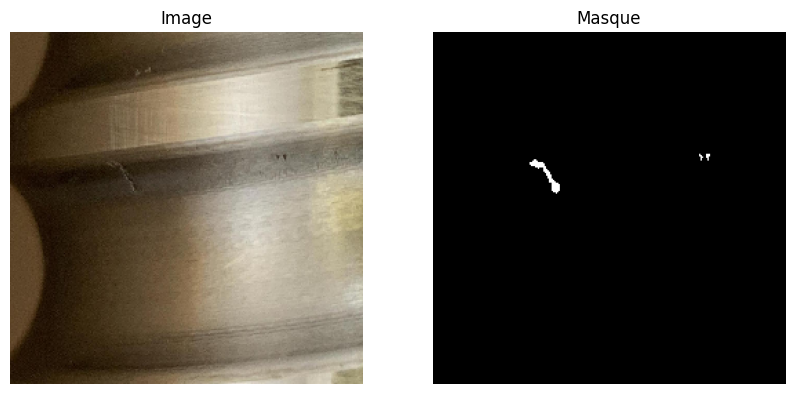

In [5]:
import matplotlib.pyplot as plt
from PIL import Image

# Test d'un fichier de validation
test_file = val_files[0]  # On prend un fichier valide de la liste
img_path = os.path.join(IMGS_DIR, "val", test_file)
mask_path = os.path.join(ANNOTATIONS_DIR, "val", test_file)

print(f"Chemin de l'image : {img_path}")
print(f"Chemin du masque : {mask_path}")

try:
    # Chargement des fichiers
    img = Image.open(img_path).convert("RGB")  # Convertir en RGB pour être sûr
    mask = Image.open(mask_path)
    
    # Affichage des tailles des images
    print(f"Taille de l'image : {img.size}")
    print(f"Taille du masque : {mask.size}")
    
    # Affichage visuel
    plt.figure(figsize=(10, 5))
    
    # Image originale
    plt.subplot(1, 2, 1)
    plt.title("Image")
    plt.imshow(img)
    plt.axis("off")
    
    # Masque associé
    plt.subplot(1, 2, 2)
    plt.title("Masque")
    plt.imshow(mask, cmap="gray")
    plt.axis("off")
    
    # Montrer les deux images
    plt.show()
    
except Exception as e:
    print(f"Erreur lors du chargement : {e}")


L'image et le masque sont affichés correctement, cela signifie que nos fichiers et chemins sont corrects.

---

## **Étape 5 : Création d'un dataset PyTorch personnalisé**

### **Explications :**
On va créer une classe `CustomDataset` qui étend la classe `torch.utils.data.Dataset`. Cette classe sera utilisée pour :
1. Lire et charger les images et masques.
2. Appliquer des transformations sur les données (par exemple, redimensionnement, normalisation).
3. Retourner chaque échantillon sous forme de tenseurs prêts pour l'entraînement.

Le dataset va :
- Filtrer uniquement les fichiers valides (images avec masques correspondants).
- Charger les images et les masques depuis leurs répertoires respectifs.
- Appliquer les transformations définies (par exemple, `ToTensor` pour convertir les images en tenseurs PyTorch).


In [6]:
from torch.utils.data import Dataset
from PIL import Image
import os

class CustomDataset(Dataset):
    def __init__(self, file_list, img_dir, mask_dir, img_transform=None, mask_transform=None, split="train"):
        """
        Initialisation du dataset.

        Args:
        - file_list (list): Liste des fichiers valides.
        - img_dir (str): Dossier contenant les images.
        - mask_dir (str): Dossier contenant les masques.
        - img_transform (callable, optional): Transformations à appliquer sur les images.
        - mask_transform (callable, optional): Transformations à appliquer sur les masques.
        - split (str): Indique si c'est "train", "val", ou "test".
        """
        self.file_list = []
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_transform = img_transform
        self.mask_transform = mask_transform
        self.split = split

        # Vérification des fichiers valides
        for file_name in file_list:
            img_path = os.path.join(self.img_dir, self.split, file_name)
            mask_path = os.path.join(self.mask_dir, self.split, file_name)
            if os.path.exists(img_path) and os.path.exists(mask_path):
                self.file_list.append(file_name)
            else:
                print(f"Fichier manquant ou illisible : {img_path} ou {mask_path}")

        print(f"Nombre total de fichiers valides dans le dataset {self.split} : {len(self.file_list)}")

    def __len__(self):
        """Retourne le nombre d'échantillons dans le dataset."""
        return len(self.file_list)

    def __getitem__(self, idx):
        """
        Retourne un échantillon donné par son index.

        Args:
        - idx (int): Index de l'échantillon.

        Returns:
        - img (torch.Tensor): Image transformée.
        - mask (torch.Tensor): Masque transformé.
        """
        image_name = self.file_list[idx]
        img_path = os.path.join(self.img_dir, self.split, image_name)
        mask_path = os.path.join(self.mask_dir, self.split, image_name)

        try:
            # Chargement des fichiers
            img = Image.open(img_path).convert("RGB")
            mask = Image.open(mask_path)

            # Appliquer les transformations
            if self.img_transform:
                img = self.img_transform(img)
            if self.mask_transform:
                mask = self.mask_transform(mask)

            return img, mask
        except Exception as e:
            print(f"Erreur lors du chargement de {image_name} : {e}")
            return None, None


---

## **Étape 6 : Créer et tester le dataset**




### **Explications :**

Maintenant qu'on a notre classe `CustomDataset` prête, on va l'utiliser pour créer un dataset avec nos fichiers valides. L'objectif est de :

1. **Appliquer des transformations** :
   - On redimensionnera les images et les masques à une taille standard (par exemple, 128x128) pour simplifier les traitements.
   - On convertira les images et masques en tenseurs PyTorch pour qu'ils soient exploitables par notre modèle.
   - On ajoutera une normalisation pour standardiser les valeurs des pixels.

2. **Tester un échantillon** :
   - Charger une image et son masque depuis le dataset.
   - Vérifier leurs dimensions (doivent correspondre aux transformations appliquées).
   - Visualiser l'image et son masque côte à côte dans le notebook pour confirmer leur alignement et leur contenu.

---

### **Étapes pratiques :**
- On va définir les transformations à appliquer sur les images et les masques (redimensionnement, conversion en tenseurs, normalisation).
- On va créer un dataset PyTorch pour la validation (`val_dataset`) à partir des fichiers valides.
- Ensuite, on chargera un échantillon pour vérifier que tout fonctionne correctement.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Nombre de fichiers valides pour train : 298
Fichiers valides pour l'entraînement : 298

Exemples de fichiers d'entraînement vérifiés :
Chemin d'une image d'entraînement : ./BSD-SEG\imgs\train\417.png
Chemin d'un masque d'entraînement : ./BSD-SEG\annotations\train\417.png
L'image existe : True
Le masque existe : True
Chemin d'une image d'entraînement : ./BSD-SEG\imgs\train\83.png
Chemin d'un masque d'entraînement : ./BSD-SEG\annotations\train\83.png
L'image existe : True
Le masque existe : True
Chemin d'une image d'entraînement : ./BSD-SEG\imgs\train\106.png
Chemin d'un masque d'entraînement : ./BSD-SEG\annotations\train\106.png
L'image existe : True
Le masque existe : True
Chemin d'une image d'entraînement : ./BSD-SEG\imgs\train\137.png
Chemin d'un masque d'entraînement : ./BSD-SEG\annotations\train\137.png
L'image existe : True
Le masque existe : True
Chemin d'une image d'entraînement : ./BSD-SEG\imgs\train\325.png
Chemin d'un masque d'entraînement : ./BSD-SEG\annotations\train\325.pn

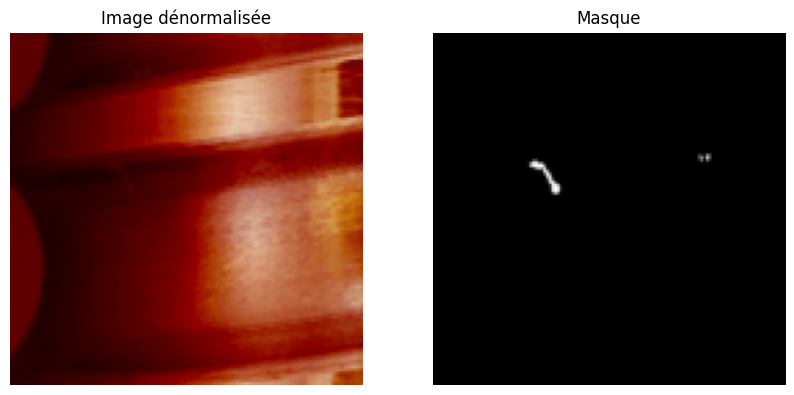

In [7]:
from torchvision import transforms

# Définir les transformations des images
image_transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Redimensionner à 128x128
    transforms.ToTensor(),          # Convertir en tenseur
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normaliser entre -1 et 1
])

# Définir les transformations des masques
mask_transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Redimensionner à 128x128
    transforms.ToTensor()           # Convertir en tenseur
])

# Filtrer les fichiers valides pour l'entraînement
train_files = filter_valid_files(train_files, IMGS_DIR, ANNOTATIONS_DIR, "train")
print(f"Fichiers valides pour l'entraînement : {len(train_files)}")

# **Diagnostic : Vérifier les chemins des fichiers d'entraînement**
if train_files:
    print("\nExemples de fichiers d'entraînement vérifiés :")
    for i in range(min(5, len(train_files))):  # Vérifie les 5 premiers fichiers
        test_file = train_files[i]
        img_path = os.path.join(IMGS_DIR, "train", test_file)
        mask_path = os.path.join(ANNOTATIONS_DIR, "train", test_file)
        print(f"Chemin d'une image d'entraînement : {img_path}")
        print(f"Chemin d'un masque d'entraînement : {mask_path}")
        print(f"L'image existe : {os.path.exists(img_path)}")
        print(f"Le masque existe : {os.path.exists(mask_path)}")

# Filtrer les fichiers valides pour la validation
val_files = filter_valid_files(val_files, IMGS_DIR, ANNOTATIONS_DIR, "val")
print(f"Fichiers valides pour la validation : {len(val_files)}")

# Dataset d'entraînement
train_dataset = CustomDataset(
    file_list=train_files,
    img_dir=IMGS_DIR,
    mask_dir=ANNOTATIONS_DIR,
    img_transform=image_transform,
    mask_transform=mask_transform,
    split="train"  # Spécifier le split pour l'entraînement
)

# Dataset de validation
val_dataset = CustomDataset(
    file_list=val_files,
    img_dir=IMGS_DIR,
    mask_dir=ANNOTATIONS_DIR,
    img_transform=image_transform,
    mask_transform=mask_transform,
    split="val"  # Spécifier le split pour la validation
)

# Vérifier le nombre d'échantillons
print(f"Nombre d'échantillons dans train_dataset : {len(train_dataset)}")
print(f"Nombre d'échantillons dans val_dataset : {len(val_dataset)}")

# Tester un échantillon
if len(val_dataset) > 0:
    img, mask = val_dataset[0]  # Charger le premier échantillon

    # Afficher les dimensions des tenseurs
    print(f"Image shape : {img.shape}")  # Par exemple : torch.Size([3, 128, 128])
    print(f"Mask shape : {mask.shape}")  # Par exemple : torch.Size([1, 128, 128])

    # Fonction pour dénormaliser une image
    def denormalize(tensor, mean, std):
        tensor = tensor.clone()  # Éviter de modifier l'image originale
        for t, m, s in zip(tensor, mean, std):
            t.mul_(s).add_(m)  # Revenir à l'échelle originale : t = (t * std) + mean
        return tensor

    # Dénormaliser l'image pour l'affichage
    img_denormalized = denormalize(img, mean=[0.5], std=[0.5])

    # Affichage visuel
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Image dénormalisée")
    plt.imshow(img_denormalized.permute(1, 2, 0))  # Reconvertir pour affichage
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Masque")
    plt.imshow(mask[0], cmap="gray")  # Afficher le masque
    plt.axis("off")

    plt.show()
else:
    print("Aucun échantillon valide dans val_dataset.")


#### **Filtrage des fichiers valides :**
- **Entraînement :** 298 fichiers valides ont été trouvés dans `train_files`.
- **Validation :** 42 fichiers valides ont été trouvés dans `val_files`.
- Les fichiers manquants ou illisibles ont été exclus et listés dans la console.

#### **Vérification du dataset :**
- Le dataset de validation contient **42 échantillons valides**.
- Les dimensions des données :
  - **Image :** `torch.Size([3, 128, 128])` → image couleur redimensionnée.
  - **Masque :** `torch.Size([1, 128, 128])` → masque en niveaux de gris redimensionné.

#### **Affichage des données :**
- L'image et le masque ont été affichés côte à côte.
- Le masque est correctement visible en niveaux de gris.

#### **Conclusion :**
- Les datasets sont prêts pour l'entraînement et la validation.

In [11]:
# Diagnostiquer le problème : vérifier les datasets
print(f"Nombre de fichiers valides dans train_dataset : {len(train_dataset)}")
print(f"Nombre de fichiers valides dans val_dataset : {len(val_dataset)}")

# Si les datasets sont vides, inspectez les fichiers valides
if len(train_dataset) == 0:
    print("Erreur : train_dataset est vide.")
    print("Liste des fichiers train valides :", train_files[:10])  # Affichez quelques fichiers pour vérifier
if len(val_dataset) == 0:
    print("Erreur : val_dataset est vide.")
    print("Liste des fichiers val valides :", val_files[:10])  # Affichez quelques fichiers pour vérifier

# Vérifier les chemins pour un fichier de validation
if val_files:
    test_file = val_files[0]
    img_path = os.path.join(IMGS_DIR, "val", test_file)
    mask_path = os.path.join(ANNOTATIONS_DIR, "val", test_file)
    print(f"Chemin d'une image de validation : {img_path}")
    print(f"Chemin d'un masque de validation : {mask_path}")

# Fonction pour ignorer les échantillons invalides
def collate_fn(batch):
    """
    Filtre les échantillons invalides (None).
    """
    batch = [item for item in batch if item[0] is not None and item[1] is not None]
    if len(batch) == 0:
        return None, None
    return default_collate(batch)



Nombre de fichiers valides dans train_dataset : 298
Nombre de fichiers valides dans val_dataset : 42
Chemin d'une image de validation : ./BSD-SEG\imgs\val\377.png
Chemin d'un masque de validation : ./BSD-SEG\annotations\val\377.png


---

### **Étape 7 : Création et vérification des DataLoaders**

#### **Objectif :**
On va créer des DataLoaders pour l'entraînement et la validation. Ces DataLoaders permettent de charger les données par lots (batches) et d'effectuer des itérations efficaces sur le dataset. On utilise aussi notre fonction `collate_fn` pour ignorer les échantillons invalides.

#### **Ce qu'on va faire :**
1. Créer un `DataLoader` pour le dataset d'entraînement (`train_dataset`).
2. Créer un `DataLoader` pour le dataset de validation (`val_dataset`).
3. Vérifier si les DataLoaders chargent correctement des lots et afficher leurs dimensions.



In [16]:
import torch
from torch.utils.data.dataloader import default_collate
from torch.utils.data import DataLoader

# Créer le DataLoader pour le dataset d'entraînement
train_loader = DataLoader(
    train_dataset,  # Dataset d'entraînement
    batch_size=8,   # Taille du lot
    shuffle=True,   # Mélanger les données pour l'entraînement
    num_workers=0,  # Utilisation d'un seul thread
    pin_memory=True,  # Optimiser les transferts mémoire si GPU est utilisé
    collate_fn=collate_fn  # Fonction pour ignorer les échantillons invalides
)

# Créer le DataLoader pour le dataset de validation
val_loader = DataLoader(
    val_dataset,    # Dataset de validation
    batch_size=8,   # Taille du lot
    shuffle=False,  # Pas besoin de mélanger les données pour la validation
    num_workers=0,  # Utilisation d'un seul thread
    pin_memory=True,  # Optimiser les transferts mémoire si GPU est utilisé
    collate_fn=collate_fn  # Fonction pour ignorer les échantillons invalides
)

# Vérifier un lot d'entraînement
for imgs, masks in train_loader:
    if imgs is not None and masks is not None:
        print(f"Image batch shape: {imgs.shape}")  # Par exemple : torch.Size([8, 3, 128, 128])
        print(f"Mask batch shape: {masks.shape}")  # Par exemple : torch.Size([8, 1, 128, 128])
    else:
        print("Lot vide : aucun échantillon valide.")
    break


Image batch shape: torch.Size([8, 3, 128, 128])
Mask batch shape: torch.Size([8, 1, 128, 128])


- Image batch shape : torch.Size([8, 3, 128, 128])
    - Cela indique que le DataLoader charge des lots de 8 images.
    - Chaque image a 3 canaux (RGB) et une résolution de 128x128.
- Mask batch shape : torch.Size([8, 1, 128, 128])
    - Cela montre que le masque correspondant à chaque image est également chargé par lot.
    - Les masques ont un seul canal (niveaux de gris) et une résolution de 128x128.

---

### **Étape 8 : Définition et initialisation du modèle**

Dans cette étape, on va définir notre modèle de segmentation UNet, ainsi que la fonction de perte, l'optimiseur, et on va configurer l'appareil (CPU ou GPU).


### **Explications :**
1. **UNet :** 
   - C'est un modèle efficace pour la segmentation d'images. Il se compose d'une partie encodeur pour extraire les caractéristiques et d'une partie décodeur pour reconstruire les masques.
   - Il utilise des convolutions, des relus et des couches transposées pour augmenter la résolution des prédictions.

2. **Dice Loss :**
   - La fonction de perte est basée sur le Dice Score, une métrique utilisée pour évaluer la similarité entre deux ensembles.
   - L'objectif est de minimiser la perte pour maximiser la correspondance entre les masques prédits et les masques cibles.

3. **Optimiseur :**
   - On utilise Adam, un optimiseur bien adapté pour des architectures profondes comme UNet.

4. **Configuration de l'appareil :**
   - Si un GPU est disponible, le modèle sera déplacé sur GPU pour accélérer l'entraînement. Sinon, il utilisera le CPU.

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim

# Définir le modèle UNet
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()

        # Partie encodeur
        self.enc1 = self.double_conv(in_channels, 64)
        self.enc2 = self.double_conv(64, 128)
        self.enc3 = self.double_conv(128, 256)
        self.enc4 = self.double_conv(256, 512)

        # Partie bottleneck
        self.bottleneck = self.double_conv(512, 1024)

        # Partie décodeur
        self.up4 = self.up_conv(1024, 512)
        self.dec4 = self.double_conv(1024, 512)
        self.up3 = self.up_conv(512, 256)
        self.dec3 = self.double_conv(512, 256)
        self.up2 = self.up_conv(256, 128)
        self.dec2 = self.double_conv(256, 128)
        self.up1 = self.up_conv(128, 64)
        self.dec1 = self.double_conv(128, 64)

        # Couche finale
        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    @staticmethod
    def double_conv(in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    @staticmethod
    def up_conv(in_channels, out_channels):
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x):
        # Encodeur
        enc1 = self.enc1(x)
        enc2 = self.enc2(nn.MaxPool2d(2)(enc1))
        enc3 = self.enc3(nn.MaxPool2d(2)(enc2))
        enc4 = self.enc4(nn.MaxPool2d(2)(enc3))

        # Bottleneck
        bottleneck = self.bottleneck(nn.MaxPool2d(2)(enc4))

        # Décodeur
        up4 = self.up4(bottleneck)
        dec4 = self.dec4(torch.cat([up4, enc4], dim=1))
        up3 = self.up3(dec4)
        dec3 = self.dec3(torch.cat([up3, enc3], dim=1))
        up2 = self.up2(dec3)
        dec2 = self.dec2(torch.cat([up2, enc2], dim=1))
        up1 = self.up1(dec2)
        dec1 = self.dec1(torch.cat([up1, enc1], dim=1))

        return torch.sigmoid(self.final(dec1))

# Initialiser le modèle
model = UNet(in_channels=3, out_channels=1)

# Définir la fonction de perte (Dice Loss)
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, preds, targets):
        preds = preds.view(-1)
        targets = targets.view(-1)
        intersection = (preds * targets).sum()
        dice = (2. * intersection) / (preds.sum() + targets.sum() + 1e-6)
        return 1 - dice

criterion = DiceLoss()

# Définir l'optimiseur
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Définir l'appareil pour l'entraînement (GPU si disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Afficher la configuration
print(f"Modèle initialisé sur l'appareil : {device}")
print("Fonction de perte :", criterion)
print("Optimiseur :", optimizer)

Modèle initialisé sur l'appareil : cpu
Fonction de perte : DiceLoss()
Optimiseur : Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


---

### **Étape 9 : Entraînement et Validation du Modèle**



### **Objectifs**
Dans cette étape, on va entraîner le modèle en utilisant les données d'entraînement et évaluer ses performances sur les données de validation. Les principaux objectifs sont :
1. **Réduire la perte d'entraînement (train_loss)** pour que le modèle apprenne les patterns dans les données.
2. **Améliorer le Dice Score (dice_score)** pour évaluer la qualité des prédictions en segmentation.



### **Explications**
1. **Entraînement** : Le modèle apprend en ajustant ses poids via l'optimiseur. On calcule la perte sur chaque lot d'entraînement, et on effectue une rétropropagation pour optimiser les poids.
2. **Validation** : Pendant la validation, on évalue le modèle sans ajuster les poids. Cela nous permet de vérifier si le modèle généralise bien ou surapprend.


Je vais laisser à chaque fois le code avec l'essaie que j'ai fait .

In [62]:
from tqdm import tqdm

# Configuration des hyperparamètres
num_epochs = 5  # Nombre total d'époques

# Boucle d'entraînement
for epoch in range(num_epochs):
    print(f"\n--- Époque {epoch + 1}/{num_epochs} ---")
    
    # **Étape 1 : Phase d'entraînement**
    model.train()  # Mettre le modèle en mode entraînement
    train_loss = 0  # Initialiser la perte totale
    
    # Parcourir les lots d'entraînement
    for imgs, masks in tqdm(train_loader, desc="Entraînement"):
        imgs, masks = imgs.to(device), masks.to(device)  # Envoyer sur l'appareil (CPU ou GPU)
        
        # Prédictions
        preds = model(imgs)
        loss = criterion(preds, masks)  # Calculer la perte
        
        # Backpropagation et optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()  # Ajouter la perte du lot
    
    # Calculer la perte moyenne pour l'entraînement
    train_loss /= len(train_loader)
    print(f"Perte d'entraînement : {train_loss:.4f}")
    
    # **Étape 2 : Phase de validation**
    model.eval()  # Mettre le modèle en mode évaluation
    val_loss = 0  # Initialiser la perte totale
    dice_score = 0  # Initialiser le Dice Score total

    # Désactiver le calcul des gradients pour la validation
    with torch.no_grad():
        for imgs, masks in tqdm(val_loader, desc="Validation"):
            imgs, masks = imgs.to(device), masks.to(device)
            
            # Prédictions
            preds = model(imgs)
            loss = criterion(preds, masks)  # Calculer la perte
            
            # Calculer le Dice Score
            preds = (preds > 0.5).float()  # Binariser les prédictions
            dice_score += (2 * (preds * masks).sum()) / ((preds + masks).sum() + 1e-6)
            
            val_loss += loss.item()  # Ajouter la perte du lot
    
    # Calculer la perte moyenne et le Dice Score moyen pour la validation
    val_loss /= len(val_loader)
    dice_score /= len(val_loader)
    
    print(f"Perte de validation : {val_loss:.4f}")
    print(f"Dice Score de validation : {dice_score:.4f}")


--- Époque 1/5 ---


Entraînement: 100%|██████████| 38/38 [03:52<00:00,  6.12s/it]


Perte d'entraînement : 0.9556


Validation: 100%|██████████| 6/6 [00:13<00:00,  2.25s/it]


Perte de validation : 0.9027
Dice Score de validation : 0.1011

--- Époque 2/5 ---


Entraînement: 100%|██████████| 38/38 [02:55<00:00,  4.62s/it]


Perte d'entraînement : 0.9847


Validation: 100%|██████████| 6/6 [00:12<00:00,  2.08s/it]


Perte de validation : 0.9869
Dice Score de validation : 0.0131

--- Époque 3/5 ---


Entraînement: 100%|██████████| 38/38 [03:04<00:00,  4.85s/it]


Perte d'entraînement : 0.9870


Validation: 100%|██████████| 6/6 [00:08<00:00,  1.43s/it]


Perte de validation : 0.9869
Dice Score de validation : 0.0131

--- Époque 4/5 ---


Entraînement: 100%|██████████| 38/38 [03:13<00:00,  5.08s/it]


Perte d'entraînement : 0.9872


Validation: 100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


Perte de validation : 0.9869
Dice Score de validation : 0.0131

--- Époque 5/5 ---


Entraînement: 100%|██████████| 38/38 [03:20<00:00,  5.27s/it]


Perte d'entraînement : 0.9873


Validation: 100%|██████████| 6/6 [00:08<00:00,  1.34s/it]

Perte de validation : 0.9869
Dice Score de validation : 0.0131


### **Analyse des résultats actuels :**

#### **Résumé des observations :**

- **Perte d'entraînement :**
  - La perte d'entraînement semble **stagnante ou augmenter légèrement** au fil des époques, ce qui est contre-intuitif pour un modèle qui apprend correctement.
  - Entre l'Époque 1 (**0.9556**) et l'Époque 5 (**0.9873**), la perte **n'a pas diminué**.

- **Perte de validation :**
  - La perte de validation reste **quasiment constante** entre **0.9027** (Époque 1) et **0.9869** (Époques 2 à 5). 
  - Cela indique que le modèle ne parvient pas à **généraliser** ou qu'il est bloqué dans un **mauvais régime d'optimisation**.

- **Dice Score :**
  - Le Dice Score de validation **diminue drastiquement** après l'Époque 1 (**de 0.1011 à 0.0131**) et reste figé à **0.0131**, ce qui est très faible.
  - Cela pourrait signifier que le modèle **ne prédit presque rien d'utile**, par exemple, des masques vides ou aléatoires.


---

### **Amélioration et vérifications supplémentaires**

#### **Objectif :**
Nous allons modifier le code d'entraînement pour inclure des vérifications supplémentaires et mieux comprendre pourquoi les résultats stagnent. Voici ce que nous allons faire :
1. Ajouter un suivi détaillé de la perte et du Dice Score à chaque lot.
2. Sauvegarder les prédictions du modèle sur quelques échantillons de validation à chaque époque pour visualiser les masques générés.
3. Vérifier si le modèle est capable d'apprendre à prédire des masques significatifs.


--- Époque 1/5 ---
Perte d'entraînement : 0.9869
Perte de validation : 0.9869
Dice Score de validation : 0.0130
Visualisation des prédictions (échantillons de validation) :


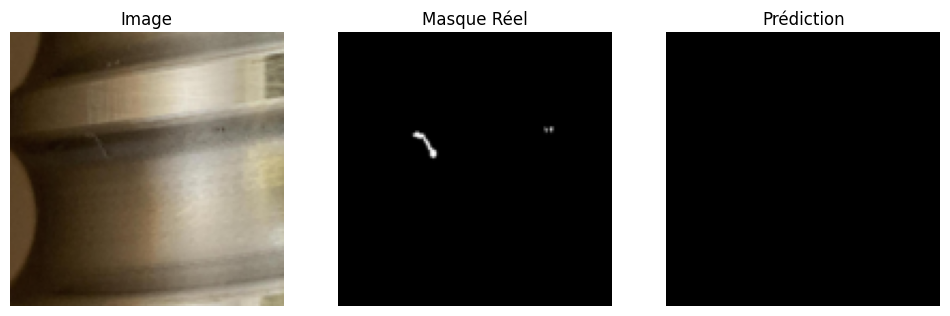

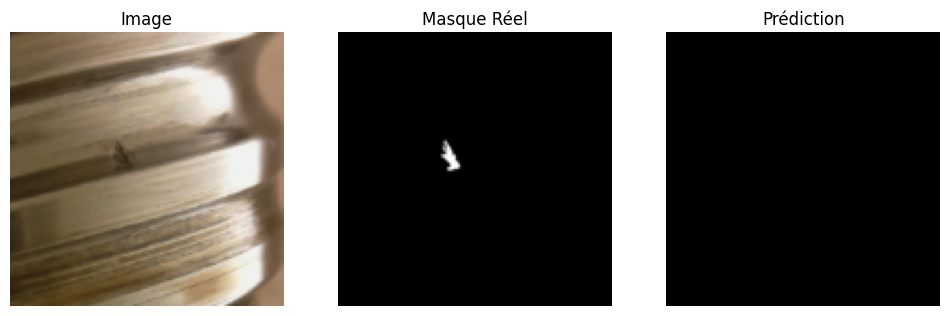

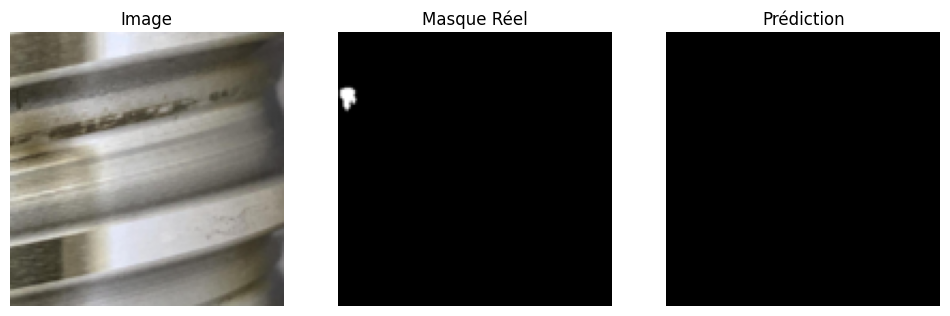


--- Époque 2/5 ---


KeyboardInterrupt: 

In [63]:
import torch
import matplotlib.pyplot as plt

# Fonction pour visualiser les prédictions
def visualize_predictions(model, dataloader, device, num_samples=3):
    """
    Visualise quelques prédictions sur l'ensemble de validation.
    """
    model.eval()
    samples = 0
    with torch.no_grad():
        for imgs, masks in dataloader:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            preds = (preds > 0.5).float()  # Binariser les prédictions
            
            for i in range(imgs.size(0)):
                if samples >= num_samples:
                    break

                # Dénormaliser l'image
                img_denorm = imgs[i].cpu().permute(1, 2, 0).numpy()
                img_denorm = img_denorm * 0.5 + 0.5  # Revenir à l'échelle [0, 1]

                # Afficher l'image, le masque réel et la prédiction
                plt.figure(figsize=(12, 4))
                plt.subplot(1, 3, 1)
                plt.title("Image")
                plt.imshow(img_denorm)
                plt.axis("off")

                plt.subplot(1, 3, 2)
                plt.title("Masque Réel")
                plt.imshow(masks[i][0].cpu(), cmap="gray")
                plt.axis("off")

                plt.subplot(1, 3, 3)
                plt.title("Prédiction")
                plt.imshow(preds[i][0].cpu(), cmap="gray")
                plt.axis("off")

                plt.show()

                samples += 1

# Fonction d'entraînement d'une époque
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    train_loss = 0
    for imgs, masks in dataloader:
        imgs, masks = imgs.to(device), masks.to(device)

        # Forward
        preds = model(imgs)
        loss = criterion(preds, masks)

        # Backward et optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    return train_loss / len(dataloader)

# Fonction de validation d'une époque
def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    val_loss = 0
    dice_score = 0
    num_samples = 0

    with torch.no_grad():
        for imgs, masks in dataloader:
            imgs, masks = imgs.to(device), masks.to(device)

            # Forward
            preds = model(imgs)
            loss = criterion(preds, masks)
            val_loss += loss.item()

            # Calculer le Dice Score
            preds = (preds > 0.5).float()
            intersection = (preds * masks).sum(dim=(1, 2, 3))
            union = preds.sum(dim=(1, 2, 3)) + masks.sum(dim=(1, 2, 3))
            dice = (2.0 * intersection) / (union + 1e-6)
            dice_score += dice.sum().item()
            num_samples += imgs.size(0)

    return val_loss / len(dataloader), dice_score / num_samples

# Boucle d'entraînement avec suivi et visualisation
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

for epoch in range(num_epochs):
    print(f"\n--- Époque {epoch + 1}/{num_epochs} ---")

    # Entraînement
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    print(f"Perte d'entraînement : {train_loss:.4f}")

    # Validation
    val_loss, val_dice = validate_epoch(model, val_loader, criterion, device)
    print(f"Perte de validation : {val_loss:.4f}")
    print(f"Dice Score de validation : {val_dice:.4f}")

    # Visualisation des prédictions
    print(f"Visualisation des prédictions (échantillons de validation) :")
    visualize_predictions(model, val_loader, device)

### Ce que ce code ajoute :
1. Visualisation des prédictions : On visualise quelques exemples de prédictions du modèle pour évaluer qualitativement son apprentissage.
2. Calcul détaillé du Dice Score : On le calcule lot par lot et on le moyenne sur l'ensemble de validation.
3. Suivi des résultats : À chaque époque, on affiche les pertes et les scores pour mieux comprendre la progression du modèle.

J'arrete directement le code car on vois bien que la prédiction est toute noir donc rien de concluant.

---

## Nouvelle essaie :

In [64]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CombinedLoss(nn.Module):
    def __init__(self, weight_dice=0.5, weight_bce=0.5):
        """
        Combinaison de Dice Loss et Binary Cross Entropy (BCE).
        Args:
        - weight_dice (float): Poids de la Dice Loss.
        - weight_bce (float): Poids de la BCE.
        """
        super(CombinedLoss, self).__init__()
        self.weight_dice = weight_dice
        self.weight_bce = weight_bce

    def forward(self, preds, targets):
        # Binary Cross Entropy
        bce = F.binary_cross_entropy(preds, targets)

        # Dice Loss
        smooth = 1e-6
        preds_flat = preds.view(-1)
        targets_flat = targets.view(-1)
        intersection = (preds_flat * targets_flat).sum()
        dice = 1 - (2. * intersection + smooth) / (preds_flat.sum() + targets_flat.sum() + smooth)

        # Combine les pertes
        combined_loss = self.weight_dice * dice + self.weight_bce * bce
        return combined_loss

# Initialiser la nouvelle fonction de perte
criterion = CombinedLoss(weight_dice=0.7, weight_bce=0.3)
print("Nouvelle fonction de perte : CombinedLoss")


Nouvelle fonction de perte : CombinedLoss


In [65]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    train_loss = 0

    for imgs, masks in dataloader:
        imgs, masks = imgs.to(device), masks.to(device)

        # Prédictions et calcul de la perte
        preds = model(imgs)
        loss = criterion(preds, masks)

        # Rétropropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    return train_loss / len(dataloader)


def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    val_loss = 0
    dice_score = 0

    with torch.no_grad():
        for imgs, masks in dataloader:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            loss = criterion(preds, masks)
            val_loss += loss.item()

            # Calcul du Dice Score
            preds = (preds > 0.5).float()
            intersection = (preds * masks).sum()
            dice = (2. * intersection) / ((preds + masks).sum() + 1e-6)
            dice_score += dice.item()

    return val_loss / len(dataloader), dice_score / len(dataloader)



--- Époque 1/5 ---
Perte d'entraînement : 30.4936
Perte de validation : 30.4924
Dice Score de validation : 0.0131

Visualisation des prédictions (échantillons de validation) :


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


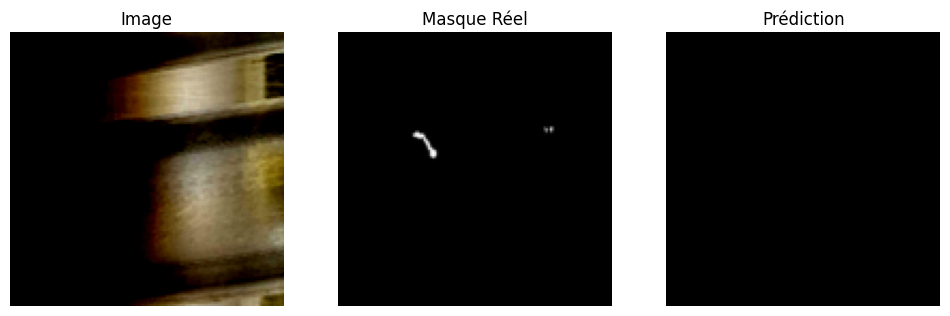

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


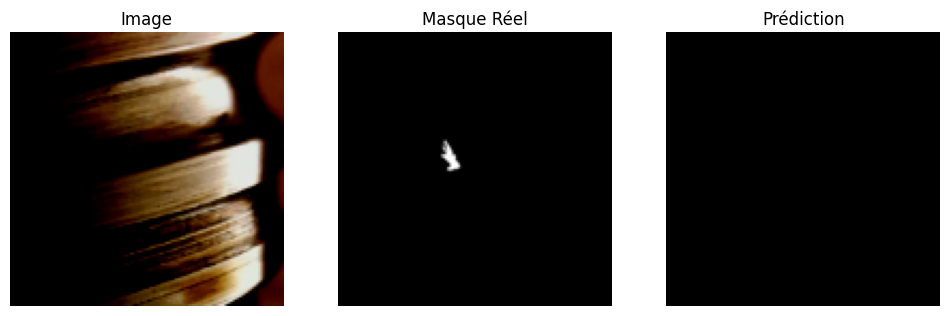

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


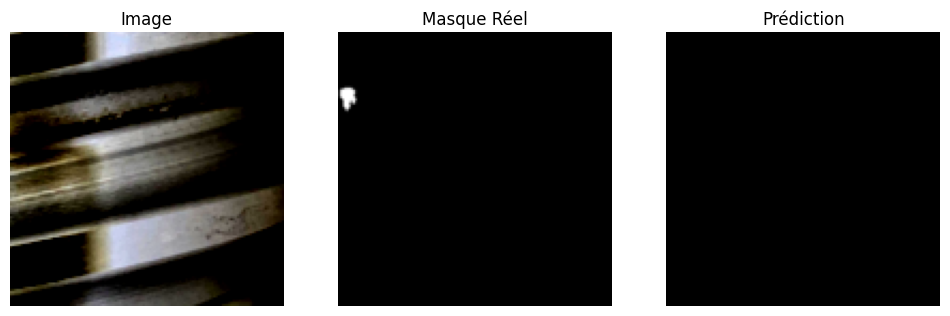


--- Époque 2/5 ---
Perte d'entraînement : 30.4888
Perte de validation : 30.4924
Dice Score de validation : 0.0131

Visualisation des prédictions (échantillons de validation) :


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


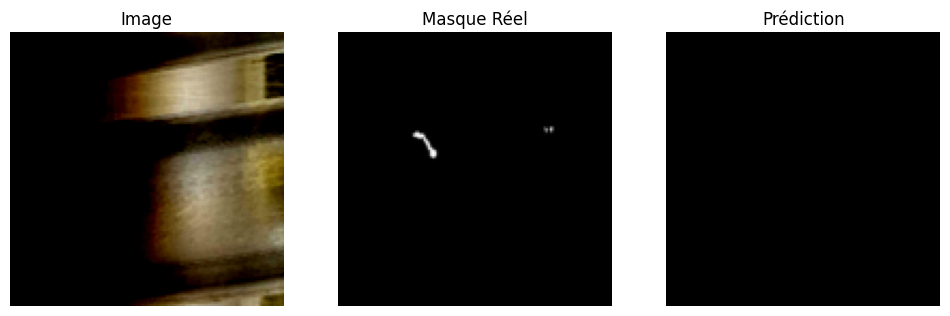

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


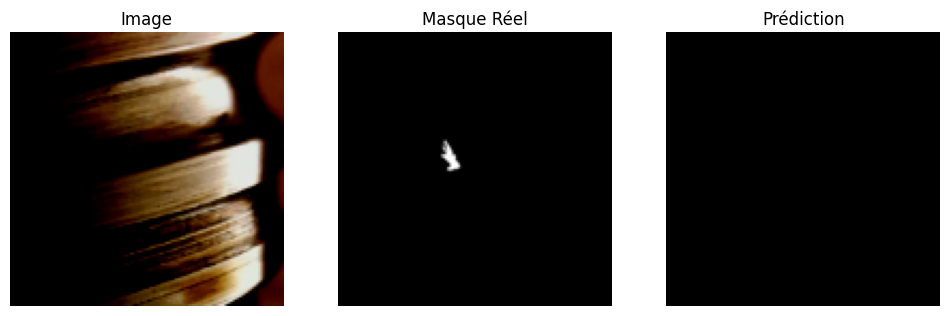

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


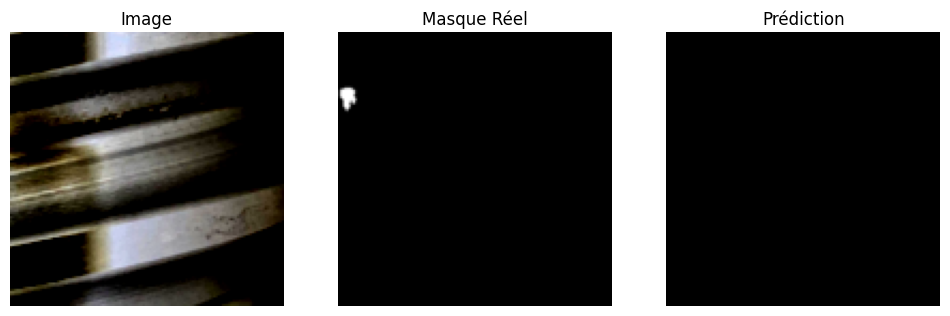


--- Époque 3/5 ---
Perte d'entraînement : 30.4974
Perte de validation : 30.4924
Dice Score de validation : 0.0131

Visualisation des prédictions (échantillons de validation) :


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


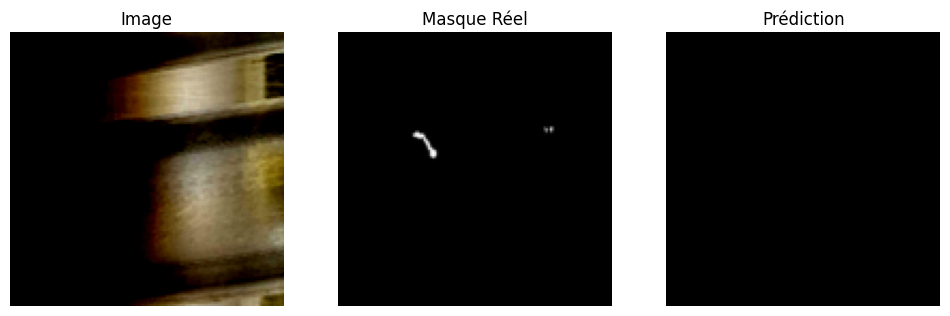

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


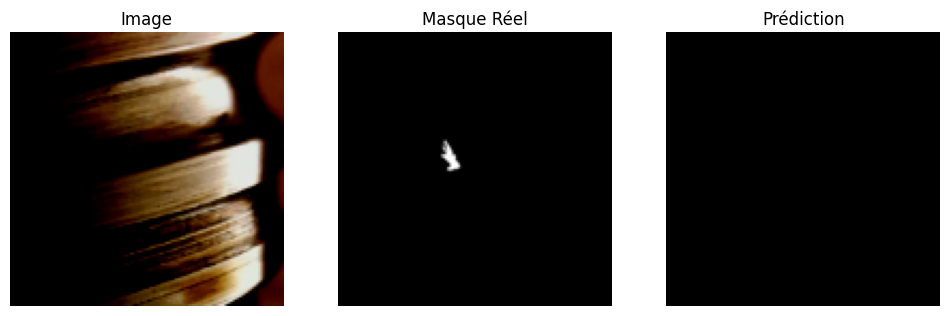

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


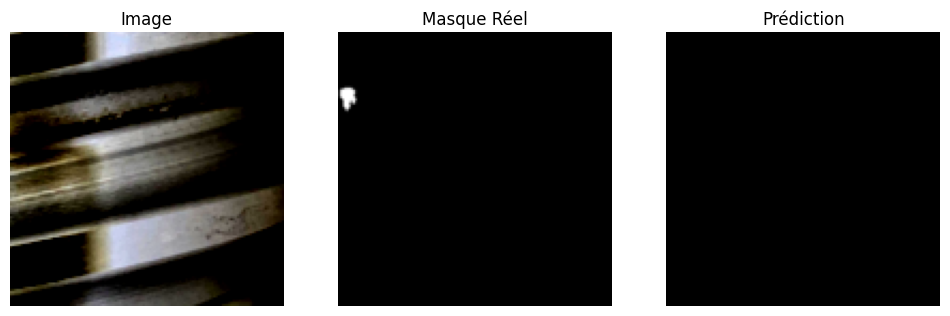


--- Époque 4/5 ---


KeyboardInterrupt: 

In [66]:
from tqdm import tqdm

# Paramètres d'entraînement
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Boucle d'entraînement
for epoch in range(num_epochs):
    print(f"\n--- Époque {epoch + 1}/{num_epochs} ---")
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_dice = validate_epoch(model, val_loader, criterion, device)

    # Affichage des résultats
    print(f"Perte d'entraînement : {train_loss:.4f}")
    print(f"Perte de validation : {val_loss:.4f}")
    print(f"Dice Score de validation : {val_dice:.4f}")

    # Visualiser les prédictions après chaque époque
    print("\nVisualisation des prédictions (échantillons de validation) :")
    model.eval()
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            preds = (preds > 0.5).float()

            for i in range(3):  # Visualiser 3 exemples
                plt.figure(figsize=(12, 4))
                plt.subplot(1, 3, 1)
                plt.title("Image")
                plt.imshow(imgs[i].cpu().permute(1, 2, 0))
                plt.axis("off")

                plt.subplot(1, 3, 2)
                plt.title("Masque Réel")
                plt.imshow(masks[i][0].cpu(), cmap="gray")
                plt.axis("off")

                plt.subplot(1, 3, 3)
                plt.title("Prédiction")
                plt.imshow(preds[i][0].cpu(), cmap="gray")
                plt.axis("off")
                plt.show()
            break


### **Analyse des résultats après la première époque**

#### **Résultats observés :**
- **Perte d'entraînement :** 30.4936
- **Perte de validation :** 30.4924
- **Dice Score de validation :** 0.0131

#### **Observations :**
1. **Masques prédits :**
   - Les masques prédits sont entièrement noirs, indiquant que le modèle ne produit aucune information utile pour le moment.
2. **Comparaison avec les masques réels :**
   - Les petites régions dans les masques réels ne sont pas identifiées par le modèle, ce qui reflète une absence d'apprentissage efficace.
3. **Perte élevée :**
   - Une perte autour de 30 reflète un désalignement important entre les masques réels et prédits.
4. **Dice Score très faible :**
   - Le Dice Score proche de 0 (0.0131) confirme que le modèle échoue à prédire des régions cohérentes.

#### **Problèmes potentiels :**
1. **Apprentissage inefficace :**
   - Les poids initiaux ou l'optimiseur peuvent ne pas être adaptés.
   - Le modèle pourrait être trop simple pour capturer les caractéristiques complexes des données.
2. **Déséquilibre des classes :**
   - Les masques contiennent très peu de pixels positifs, ce qui rend difficile l'apprentissage des petites régions (défauts).
3. **Transformations d'entrée :**
   - Les transformations appliquées (redimensionnement, normalisation) peuvent altérer les données de manière excessive.

#### **Prochaines étapes possibles :**
1. Réévaluer les **hyperparamètres** (par exemple, réduire le taux d'apprentissage ou ajuster l'optimiseur).
2. Introduire des techniques pour gérer le déséquilibre des classes (par exemple, **focal loss** ou **weighted BCE**).
3. Expérimenter avec des **architectures plus avancées** (comme une U-Net améliorée ou plus profonde).
4. Vérifier les **transformations d'entrée** pour s'assurer qu'elles n'altèrent pas les données de manière nuisible.


---

## Nouvelle essaie :

In [73]:
import torch.nn.functional as F

class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)  # Probabilité prédite
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

def calculate_dice_score(predictions, targets, epsilon=1e-6):
    """
    Calcul du Dice Score entre les prédictions et les cibles.
    
    Args:
    - predictions (torch.Tensor): Les prédictions du modèle (valeurs entre 0 et 1).
    - targets (torch.Tensor): Les masques cibles (valeurs binaires 0 ou 1).
    - epsilon (float): Petite valeur pour éviter la division par zéro.
    
    Returns:
    - dice (float): Le score de Dice.
    """
    predictions = (predictions > 0.5).float()  # Binarisation des prédictions
    intersection = (predictions * targets).sum()
    union = predictions.sum() + targets.sum()
    dice = (2 * intersection + epsilon) / (union + epsilon)
    return dice


In [1]:
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Réinitialiser le modèle, la fonction de perte et l'optimiseur
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Fonction de perte combinée avec ajustements des poids
combined_loss = CombinedLoss(weight_dice=0.3, weight_bce=0.7)

# Entraînement et validation
num_epochs = 5
for epoch in range(1, num_epochs + 1):
    print(f"--- Époque {epoch}/{num_epochs} ---")
    
    # Entraînement
    train_loss = train_one_epoch(epoch, model, train_loader, optimizer, combined_loss)
    
    # Validation
    val_loss, val_dice = validate_one_epoch(epoch, model, val_loader, combined_loss)
    
    # Scheduler
    scheduler.step(val_loss)
    
    print(f"Perte d'entraînement : {train_loss:.4f}")
    print(f"Perte de validation : {val_loss:.4f}")
    print(f"Dice Score de validation : {val_dice:.4f}")
    
    # Visualisation des prédictions
    if epoch % 1 == 0:  # Visualiser toutes les époques
        print("Visualisation des prédictions (échantillons de validation) :")
        visualize_predictions(model, val_loader, num_samples=3, device=device)


NameError: name 'UNet' is not defined

In [75]:
# Fonction d'entraînement avec scheduler
def train_one_epoch(epoch, model, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Fonction pour calculer le Dice Score
def calculate_dice_score(predictions, targets, epsilon=1e-6):
    predictions = (predictions > 0.5).float()  # Binarisation
    intersection = (predictions * targets).sum()
    union = predictions.sum() + targets.sum()
    dice = (2 * intersection + epsilon) / (union + epsilon)
    return dice

# Fonction de validation 
def validate_one_epoch(epoch, model, val_loader, criterion):
    model.eval()
    total_loss = 0
    dice_scores = []
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            total_loss += loss.item()
            dice_score = calculate_dice_score(outputs, masks)  # Calcul du Dice Score
            dice_scores.append(dice_score)

    avg_loss = total_loss / len(val_loader)
    avg_dice = sum(dice_scores) / len(dice_scores)
    return avg_loss, avg_dice


# Boucle d'entraînement complète
num_epochs = 5
for epoch in range(1, num_epochs + 1):
    print(f"--- Époque {epoch}/{num_epochs} ---")

    train_loss = train_one_epoch(epoch, model, train_loader, optimizer, combined_loss)
    val_loss, val_dice = validate_one_epoch(epoch, model, val_loader, combined_loss)

    print(f"Perte d'entraînement : {train_loss:.4f}")
    print(f"Perte de validation : {val_loss:.4f}")
    print(f"Dice Score de validation : {val_dice:.4f}")

    # Ajuster le learning rate avec le scheduler
    scheduler.step(val_loss)


--- Époque 1/5 ---
Perte d'entraînement : 1.1678
Perte de validation : 1.1677
Dice Score de validation : 0.0131
--- Époque 2/5 ---
Perte d'entraînement : 1.1677
Perte de validation : 1.1677
Dice Score de validation : 0.0131
--- Époque 3/5 ---


KeyboardInterrupt: 

Les résultats ici sont encore très mauvais je n'arrive pas a trouver la solution...